In [121]:
from utils.data_process_functions import *
from utils.pca_cluster_functions import *

# Food Access Program Deployment Proposal
## Data Challenge Marco Arellano


## 1. Where should we deploy a food access program?

A clustering model was developed to identify counties with similar characteristics related to low access to stores and population health indicators, such as the estimated prevalence of chronic diseases associated with food deserts or food insecurity.

### Data
The Food Environment Access dataset (USDA, 2020) and the 500 hundred cities project (CDC, 2019) had been used for this analysis, which contains population lack of food access traits and the estimation of the prevalence of chronic diseases. 

It is important to note that the food access metrics are from 2015, while the data on diseases and health behaviors is from 2017.

Additionally, demographic traits related to low access populations were not included in the clustering analysis to prevent potential biases related to race. However, these factors were utilized to identify which subgroups within the county's population might benefit the most from the food program.

Note: The 500 Hundred cities project only had been filtered only with the affections that are related with food insecurity scenarios. 
326 counties across the united states where part of this analysis

In [122]:
# Setting working directory
directory = 'C:\\Users\\marco_ab93\\OneDrive\\Documentos\\Data_Challenge\\'
os.chdir(directory)

# Path to the .db file
db_file_path = 'challenge.db'

# Connect to the SQLite database and read tables
with sqlite3.connect(db_file_path) as conn:
    queries = {
        'access_raw': "SELECT * FROM access;",
        'five_hundred_cities_raw': "SELECT * FROM five_hundred_cities;",
        'food_env_atlas': "SELECT * FROM variable_list;"
    }
    
    # Execute queries and store results in a dictionary
    dataframes = {name: pd.read_sql_query(query, conn) for name, query in queries.items()}

# Assign DataFrames to variables
access_raw = dataframes['access_raw']
five_hundred_cities_raw = dataframes['five_hundred_cities_raw']
access_cols_dict = dataframes['food_env_atlas']

### Data Cleaning

To begin, the 500 hundred cities project dataset (`five_hundred_cities_raw`) was filter by only the columns related with location, cardiovascular diseses, insurance access and mental health disorders. 

In [123]:
# Getting the variables names for easier subseting
chronic_disease_labs, demography_labs_cnt, demography_labs_pct, percent_labs, count_labs, change_labs = data_labels(access_raw, five_hundred_cities_raw)

Because `five_hundred_cities_raw` was in Tract level, `access_raw` were merge by the FIPS codes only to have the counties labels, and then `five_hundred_cities_raw` was group by FIPS, State, and county and  finally summarized at county level. 

In [124]:
five_hundred_cities_county_level= five_hundred_cities_to_county_level(access_raw, five_hundred_cities_raw, chronic_disease_labs)

After having `five_hundred_cities` at county level, we merge it with `access_raw` to have all our metrics in just one dataset

In [125]:
access_raw['FIPS']=access_raw['FIPS'].astype(str)

# Joining both datasets
df = pd.merge(access_raw, five_hundred_cities_county_level, on='FIPS', how='inner')

# Droping repeated columns
df =df.drop(columns=['index','County_y', 'StateAbbr'], axis=1)

# Rename columns
df.rename(columns={'County_x': 'County'}, inplace=True)

In our joined dataset, `df`, is only one NA values which correspond to Alexandria county in VA State. This county was removed due to didn't have any food low access metrics.

In [126]:
# Droping NA value
# Only Alexandria county in VA State was remove
df = df.dropna()

### Analyzing outliers

Outliers segmentation:
 Identify the extremes groups with the highest access to food in the dataset and gather them in just one segment. They could be part of more detailed analysis in regard to their extreme values across all the variables included in this analysis.
Values below the .01 percentile were excluded and gathered in one group.
4 counties were excluded from the data:
- Brox, NY
- Kings, NY
- New York, NY
- Queens, NY

In [127]:
# Getting extreme cases below the 1st percentile
specific_columns = ['PCT_LACCESS_POP15']
outliers_dict, outliers_segment = identify_and_gather_lower_outliers(df, specific_columns)

In [128]:
outliers_segment

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,Population2010,ACCESS2_CrudePrev,BPHIGH_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev
180,36005,NY,Bronx,12461.685079,7135.332473,-42.741833,0.899690,0.515146,846.616493,12.741068,...,1631.604704,0.117796,3883.0,23.3,33.7,13.0,32.2,15.5,33.7,3.6
182,36047,NY,Kings,393.244691,393.244691,0.000000,0.015700,0.015700,77.572418,131.931716,...,4.871047,0.000194,3245.0,14.0,27.4,11.0,30.3,13.1,24.2,3.2
184,36061,NY,New York,2.000000,2.000000,0.000000,0.000126,0.000126,0.000000,0.000000,...,0.000000,0.000000,5504.0,8.2,23.2,7.0,28.6,10.6,14.7,2.2
186,36081,NY,Queens,7451.015214,7788.806595,4.533495,0.334018,0.349161,782.274190,714.821788,...,165.388645,0.007414,3056.0,15.0,26.9,11.2,32.1,12.4,23.3,2.8


In [129]:
# Removing only the outliers below the 1st percentile from the analysis
df = df.drop(outliers_segment.index)



The variables considered to run the clustering were:

**Food access population metrics:**

- Percentage of people with low access to stores
- Percentage of people with low income and low access to stores
- Percentage of housing units without a car and low access to stores
- Percentage of housing units receiving Supplemental Nutrition Assistance Program (SNAP) benefits and low access to stores

**Cardiovascular diseases metrics (Health indicators):**

- Estimated prevalence of uninsured adults aged 18 to 64.
- Estimated prevalence of adults aged 18 and older with high blood pressure.
- Estimated prevalence of adults aged 18 and older with diagnosed diabetes.
- Estimated prevalence of adults aged 18 and older with high cholesterol who were screened in the past 5 years.
- Estimated prevalence of adults aged 18 and older with obesity.
- Estimated prevalence of adults aged 18 and older who have had a stroke.

### Clustering Analysis Methodology

As a first step of the clustering process, our joined dataset (`df`) was subseted to get only the variables considered to run the clustering. 

Variables considered for the clustering:

**Food access population metrics:**

- Percentage of people with low access to stores
- Percentage of people with low income and low access to stores
- Percentage of housing units without a car and low access to stores
- Percentage of housing units receiving Supplemental Nutrition Assistance Program (SNAP) benefits and low access to stores

**Cardiovascular diseases metrics (Health indicators):**

- Estimated prevalence of uninsured adults aged 18 to 64.
- Estimated prevalence of adults aged 18 and older with high blood pressure.
- Estimated prevalence of adults aged 18 and older with diagnosed diabetes.
- Estimated prevalence of adults aged 18 and older with high cholesterol who were screened in the past 5 years.
- Estimated prevalence of adults aged 18 and older with obesity.
- Estimated prevalence of adults aged 18 and older who have had a stroke.

**Note:** 
- Demographic variables related to low access populations were not included in the clustering analysis to prevent potential biases related to race. However, these factors were utilized to identify which subgroups within the county's population might benefit the most from the food program.
- Percentages variables wer chosen for the clustering and PCA process because they are in the same scale which makes the scaling process more practical.

In [130]:
# Subsetting data only by the columns of interest to perform the PCA ON
df_pca = df[percent_labs + chronic_disease_labs]

### Scaling

Identifying Right Skewed variables and applying corresponding standardization

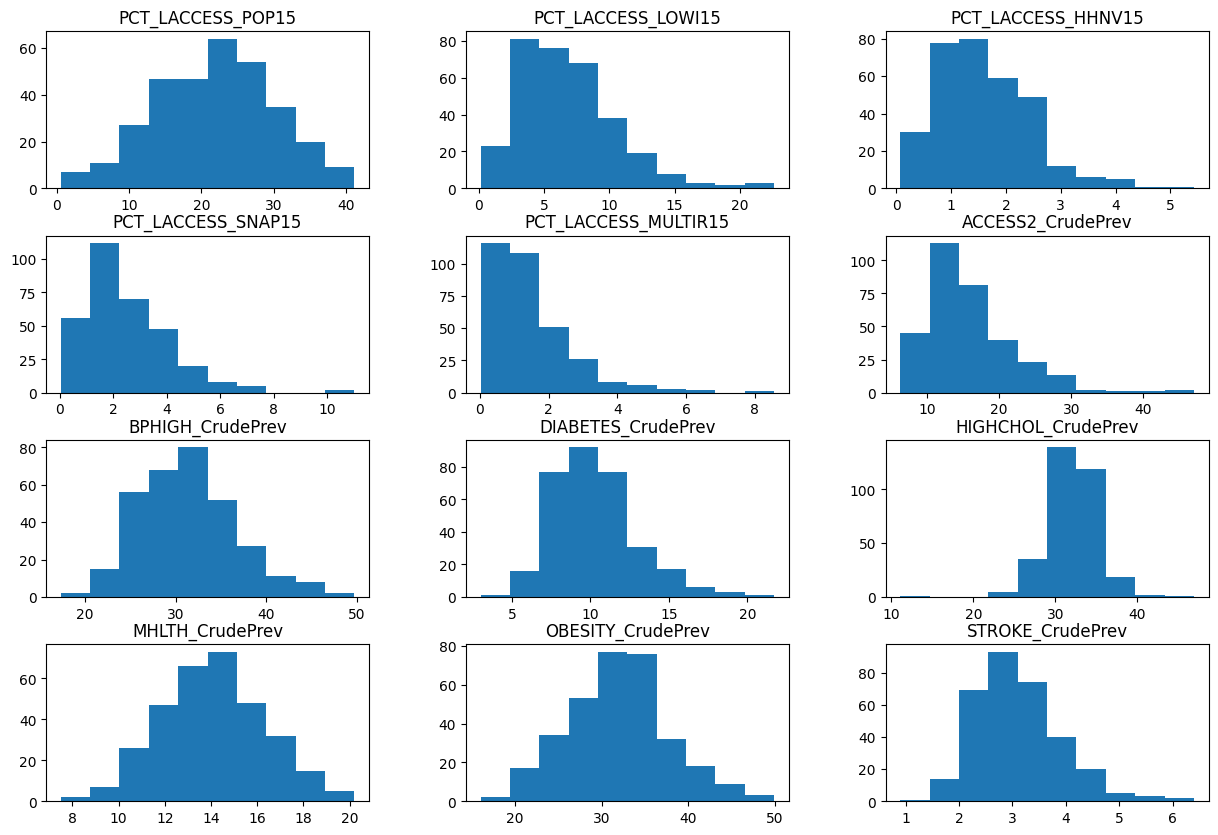

In [131]:
# Generate histograms for all numeric columns
df_pca.hist(bins=10, figsize=(15, 10), grid=False)
plt.show()

In [132]:
# Identify right-skewed columns
right_skewed_columns, not_skewed_columns = identify_right_skewed(df_pca, skew_threshold=0.5)


Z-score for no right skewed data, and Yeo-Johnson Transformation for data that is right skewed.

In [133]:
X_scaled = scale_data_skew_handling(df_pca, right_skewed_columns, not_skewed_columns)

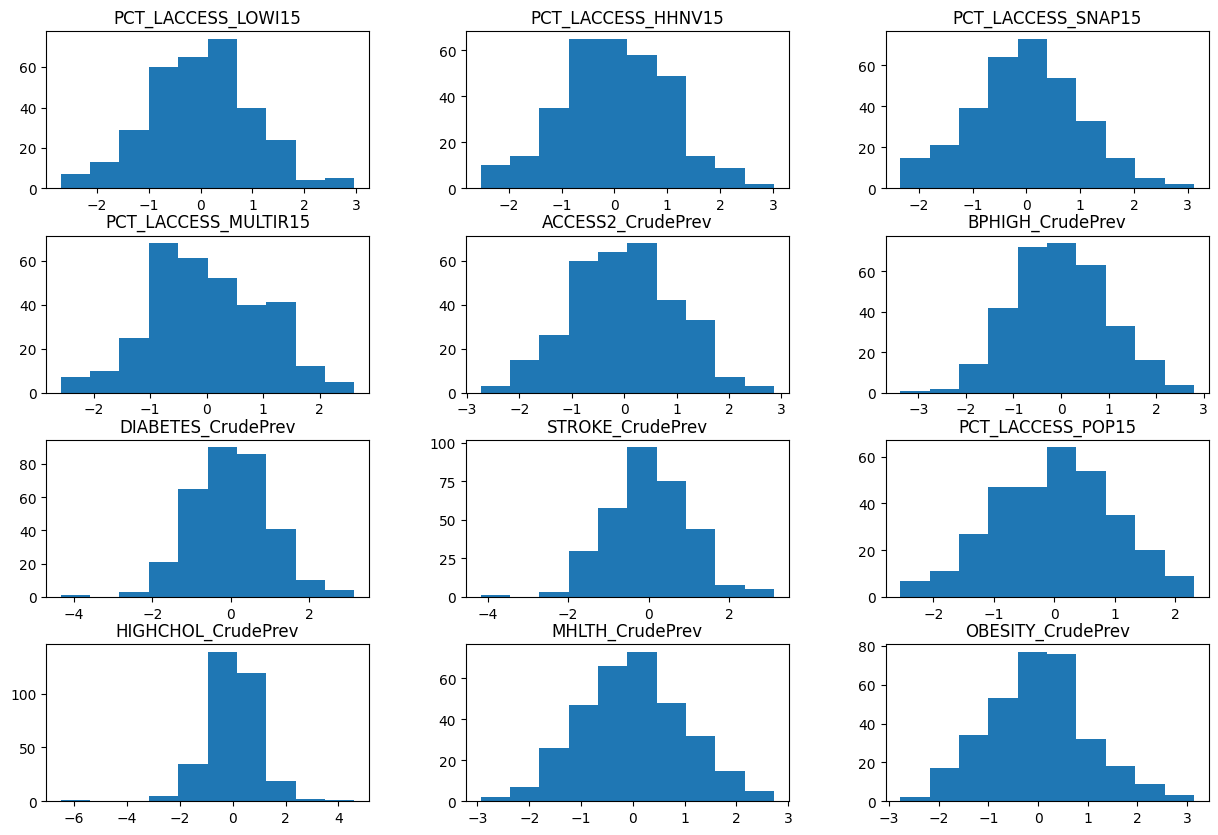

In [134]:
# Generate histograms for all numeric columns
X_scaled.hist(bins=10, figsize=(15, 10), grid=False)
plt.show()

### PCA
Identified the key components capturing the most data variability. PCA was applied exclusively to variables related to household income and chronic diseases, with two components explaining over 70% of the data variability

In [135]:
pca_df, explained_variance, loadings = perform_pca(X_scaled)

Explained Variance: [0.50904211 0.20511993 0.08230463 0.07648341 0.0318617 ]


Principal components loading heatmap.

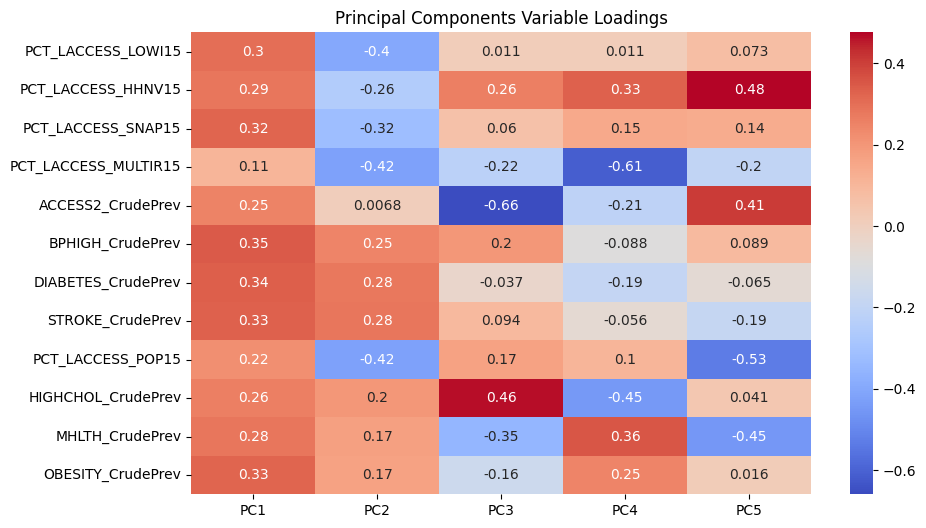

In [136]:
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm")
plt.title('Principal Components Variable Loadings')
plt.show()

### Clustering
Performed K-Means clustering to identify our groups and used the elbow plot to determine the optimal number of clusters.

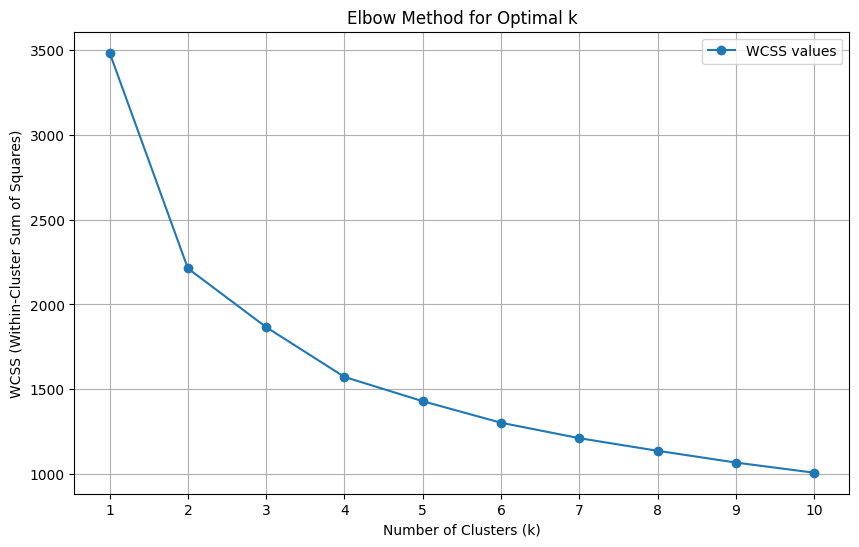

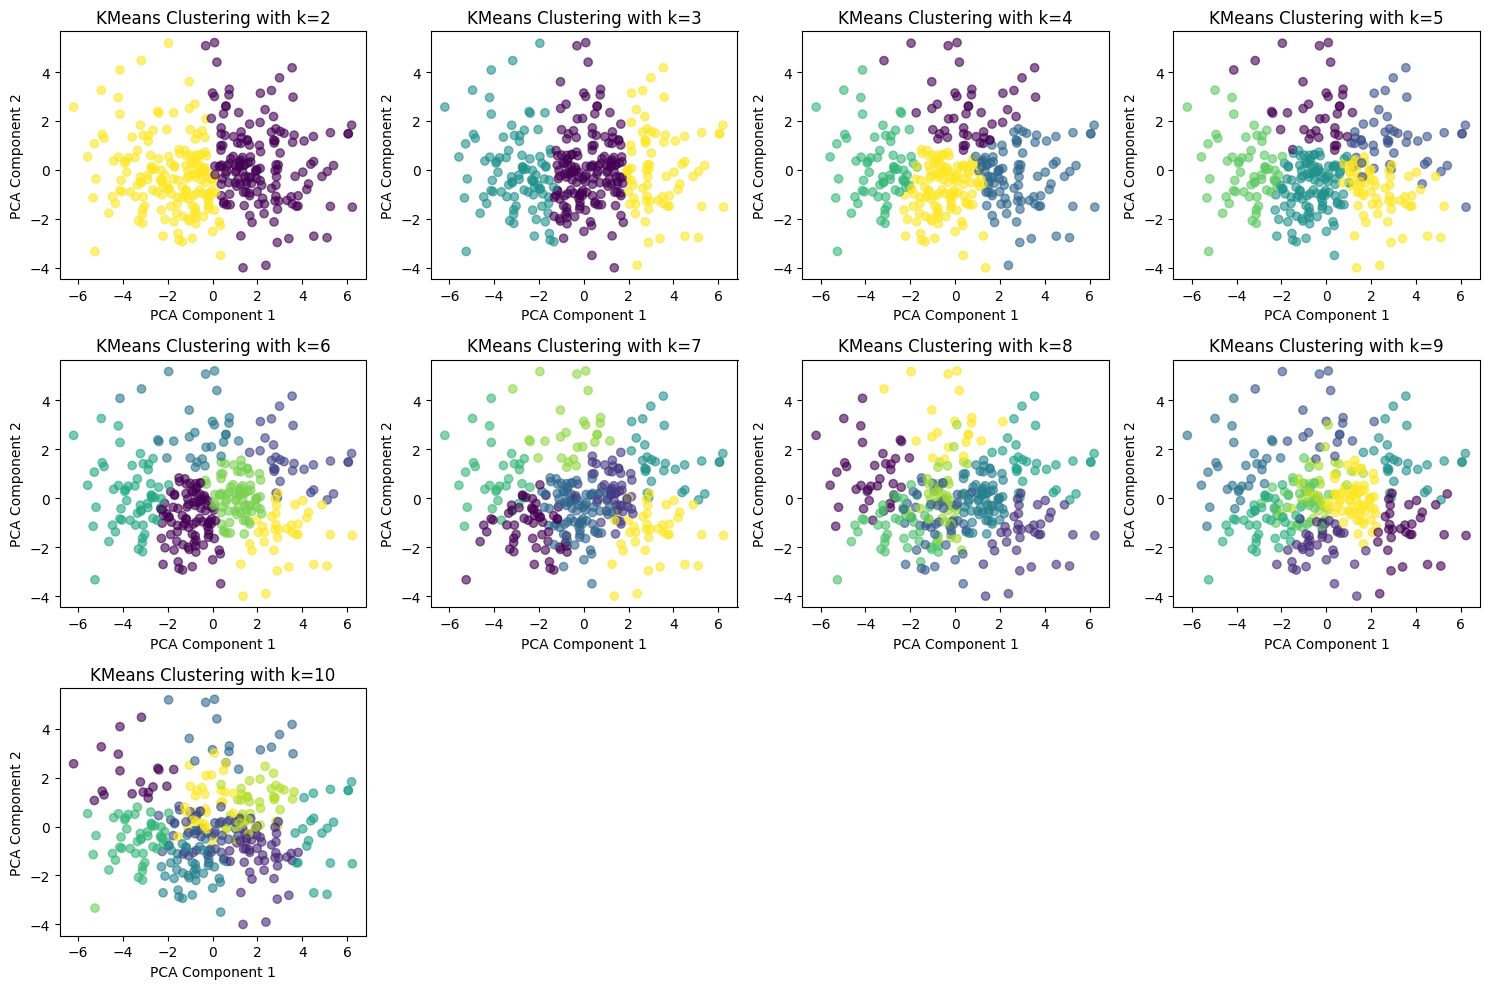

In [137]:
cluster_elbow_plot_and_pca_plot(pca_df)

Based on the Elbow plot and PCA graph, the optimal number of clusters is 3.

In [138]:
cluster_df = fitting_clusters(X_scaled, df)

After fitting the clusters, the Kruskal-Wallis test was conducted to determine if there were significant differences between them.

In [139]:
# Let's test if the clusters are different to each other using the Kruskal-Wallis Test

selected_columns = percent_labs + chronic_disease_labs

# Pass the selected columns to the function
kruskal_wallis_test_result = kruskal_wallis_clusters(cluster_df[ ['Cluster']+ selected_columns], 'Cluster')

Variable: PCT_LACCESS_POP15,
 H-statistic: 79.85249959717521,
 p-value: 4.573514174171703e-18,
 Interpretation: There are significant differences between clusters for PCT_LACCESS_POP15 (reject H0).
Variable: PCT_LACCESS_LOWI15,
 H-statistic: 152.92941981228728,
 p-value: 6.191536356476453e-34,
 Interpretation: There are significant differences between clusters for PCT_LACCESS_LOWI15 (reject H0).
Variable: PCT_LACCESS_HHNV15,
 H-statistic: 138.9588960949368,
 p-value: 6.6905081997755025e-31,
 Interpretation: There are significant differences between clusters for PCT_LACCESS_HHNV15 (reject H0).
Variable: PCT_LACCESS_SNAP15,
 H-statistic: 169.06565731385786,
 p-value: 1.9402557297581237e-37,
 Interpretation: There are significant differences between clusters for PCT_LACCESS_SNAP15 (reject H0).
Variable: PCT_LACCESS_MULTIR15,
 H-statistic: 24.942061175912386,
 p-value: 3.836191087376986e-06,
 Interpretation: There are significant differences between clusters for PCT_LACCESS_MULTIR15 (rejec

### Cluster Interpretation

21 counties across the US had been clustered in 3 main groups.

- Cluster 0 (High Access, Low Risk): High access to stores with food access and health in comparisson with the other clusters.
- Cluster 1 (Low Access, High Risk): High food access problems and severe health outcomes.
- Cluster 2 (Moderate Access, Moderate Risk): Significant health problems with moderate food access issues.

In [140]:
# Cluster Interpretation
# Used of median to have a better centrality representation
cluster_df[['Cluster'] + percent_labs+chronic_disease_labs].groupby('Cluster').mean().round(3) 

,PCT_LACCESS_POP15,PCT_LACCESS_LOWI15,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_MULTIR15,ACCESS2_CrudePrev,BPHIGH_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev
Cluster,,,,,,,,,,,,
0,15.922,3.387,0.888,1.027,0.957,11.399,25.434,7.694,29.188,11.903,26.009,2.327
1,27.162,10.028,2.298,3.938,1.695,19.478,36.504,12.763,34.242,15.884,37.079,3.827
2,20.989,6.163,1.468,2.169,1.659,15.341,30.507,9.685,31.943,13.881,31.177,2.912


In [141]:
# Group by 'Cluster' and count unique counties
cluster_df.groupby('Cluster')[['FIPS','State']].nunique().reset_index()

,Cluster,FIPS,State
0,0,74,31
1,1,106,29
2,2,141,41


Recommend implementing the food access program in the cluster with the highest vulnerability, specifically Cluster: Low Access, High Risk. Individuals in these counties face significant needs and have a heightened risk of developing chronic diseases. This cluster encompasses 79 counties across 24 states.

### Pilot Program Deployment

Our focus for implementing the program will be on the cluster: Low Access, High Risk. Based on a prioritization by vulnerability, we recommend piloting the program in the most vulnerable state to test the effectiveness of this initiative's actions.

A prioritization segmentation classified counties within clusters into three categories: high, medium, and low priority. This classification identifies the state with the highest ratio of counties in need, providing a benchmark to test the program's effectiveness in the most vulnerable communities.

In [142]:
# Creata a priority categories bases on quantile of the Low-income, low access variable. 
cluster_df = cluster_df.groupby('Cluster', group_keys=False).apply(priority_classification)

C:\Users\marco_ab93\AppData\Local\Temp\ipykernel_21876\3616640237.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_df = cluster_df.groupby('Cluster', group_keys=False).apply(priority_classification)


In [143]:
cluster_df.groupby(['Cluster', 'Priority_Category'])[['FIPS',]].nunique().reset_index()

C:\Users\marco_ab93\AppData\Local\Temp\ipykernel_21876\1597454927.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_df.groupby(['Cluster', 'Priority_Category'])[['FIPS',]].nunique().reset_index()


,Cluster,Priority_Category,FIPS
0,0,Low,25
1,0,Medium,24
2,0,High,25
3,1,Low,35
4,1,Medium,36
5,1,High,35
6,2,Low,47
7,2,Medium,47
8,2,High,47


In [144]:
High_Priority_Counties = (
        cluster_df[(cluster_df['Cluster'] == 1) &
                (cluster_df['Priority_Category'] == 'High')].
        groupby('State')['FIPS'].nunique().reset_index().
        sort_values(by = 'FIPS', ascending=False)
        )
        
High_Priority_Counties['state_ratio'] = ((High_Priority_Counties['FIPS']/High_Priority_Counties['FIPS'].sum())*100).round(3)

High_Priority_Counties       

,State,FIPS,state_ratio
12,TX,7,20.000
2,FL,5,14.286
3,GA,5,14.286
11,TN,4,11.429
8,NC,3,8.571
0,AL,2,5.714
7,MS,2,5.714
10,OK,2,5.714
1,CO,1,2.857
4,KS,1,2.857


The chosen state as our target population is the state of texas which has 7 counties with High Priority. Below the list of the counties rank by the percentage of low-income and low access population

In [145]:
cluster_df[
        (cluster_df['Cluster'] == 1) &
        (cluster_df['Priority_Category'] == 'High') & 
        (cluster_df['State'] == 'TX')][['County', 'PCT_LACCESS_LOWI15']].sort_values(by = 'PCT_LACCESS_LOWI15', ascending=False)


,County,PCT_LACCESS_LOWI15
271,Hidalgo,21.250282
276,McLennan,20.173622
285,Tom Green,16.603719
259,Cameron,14.164701
288,Wichita,12.918464
287,Webb,12.712748
284,Taylor,12.323721


**Proposed Strategy:** Deploy a pilot food access program by allocating all resources to a single state. This would allow for exploration of the program's impact and potential replication in similar populations. Consider Texas, with 12 counties prioritizing 7 which are the ones that have the highest percentage of its population with low-income and low access to stores. These areas might already be familiar with such initiatives or have existing government strategies that could enhance the effectiveness of our food access program.

In [146]:
texas = cluster_df[(cluster_df['Cluster'] == 1) &
                   (cluster_df['Priority_Category'] == 'High') & 
                   (cluster_df['State'] == 'TX')]
texas

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,Population2010,ACCESS2_CrudePrev,BPHIGH_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev,Cluster,Priority_Category
259,48061,TX,Cameron,112245.119252,100015.195854,-10.895728,27.631608,24.620943,66440.857188,57539.848402,...,3288.5,45.95,35.0,18.35,36.00,16.3,42.05,3.80,1,High
271,48215,TX,Hidalgo,330465.695700,269110.460682,-18.566295,42.653448,34.734283,205710.972505,164640.597158,...,5178.0,40.40,31.7,14.70,31.35,14.9,43.15,3.00,1,High
276,48309,TX,McLennan,66738.901183,91765.194616,37.498810,28.410897,39.064645,29367.125244,47389.049626,...,3653.0,27.00,36.3,13.50,34.90,16.9,37.00,3.60,1,High
284,48441,TX,Taylor,37888.697015,36822.041734,-2.815233,28.811383,28.000275,16178.195444,16206.432691,...,2899.0,23.60,35.0,11.50,35.80,15.5,33.70,3.50,1,High
285,48451,TX,Tom Green,33804.158288,44739.347357,32.348651,30.668601,40.589479,13172.109239,18301.283190,...,4300.0,23.90,32.3,11.15,34.25,13.5,34.65,2.95,1,High
287,48479,TX,Webb,44797.309168,56255.310872,25.577433,17.897161,22.474795,22110.378464,31820.516379,...,3799.0,47.00,32.9,16.00,34.80,17.0,44.90,3.20,1,High
288,48485,TX,Wichita,43103.772629,48641.625709,12.847722,32.778534,36.989829,16830.026209,16987.780619,...,2528.0,24.00,36.3,13.40,36.70,14.8,40.10,3.80,1,High


## 2: How many people will be included?

Our target population is low-income individuals with limited store access in the state having the highest proportion of high-priority counties within the Low Access, High Risk cluster. **This includes 7 counties in Texas, encompassing a population of 352,889 low-income individuals with limited access to stores.** They will be the focus of our initiative.

In [147]:
# Potential People Included Target State
TX_people_included = texas['LACCESS_LOWI15'].sum()
TX_people_included

352885.50806513126

### How many might be successfully engaged?
Individuals already receiving **SNAP benefits** are a promising segment of our target population, as they are familiar with food access programs. This group includes **48,624 people**.

In [148]:
# Potentially succesfully engaged people
TX_potentially_engaged = np.ceil(((texas['LACCESS_SNAP15']).sum()))
TX_potentially_engaged

48624.0

## 3: Which subgroup of the population might benefit the most from the program?

To determine which subgroup could most benefit from our pilot program, we calculated the count of people with low-income and low access in each subgroup. We then compared this count to the total population of the counties to see the percentage of the total population each subgroup represents.

Using the Food Environment Atlas's supplemental data, population estimates and demographic metrics for each county were obtained. This dataset includes the percentage of each race per county and the estimated population.

In [149]:
# Load population data for U.S. counties
population = pd.read_excel('FoodEnvironmentAtlas.xls', sheet_name='Supplemental Data - County')

# Load race percentages data for each subgroup at the county level
demography_data = pd.read_excel('FoodEnvironmentAtlas.xls', sheet_name='SOCIOECONOMIC')

In [150]:
# Joining both datas to get one unify data whith the demography paramaters
# Data population United states - County Level
population = pd.read_excel('FoodEnvironmentAtlas.xls', sheet_name='Supplemental Data - County')

# Data races perceptages for each subgroup - County Level
demography_data = pd.read_excel('FoodEnvironmentAtlas.xls', sheet_name='SOCIOECONOMIC')

population['FIPS'] = population['FIPS'].astype(str)
population_2018 = population[['FIPS','Population_Estimate_2015', 'Population_Estimate_2018']]

demography_data['FIPS'] = demography_data['FIPS'].astype(str)
demography_data = demography_data[[col for col in demography_data.columns if 'FIPS' in col or 'PCT' in col]]

pop_and_demography= pd.merge(population_2018, demography_data, on='FIPS', how='inner')

pct_cols = [col for col in pop_and_demography.columns if 'PCT' in col]

for col in pct_cols:
    pop_and_demography[f'CNT_{col.replace("PCT_","")}'] = np.ceil((pop_and_demography[col]/100)*pop_and_demography['Population_Estimate_2015'])

In [151]:
# Merge texas and populatio data and demography data to add estimated population and the count of each race in the texas data.
texas=pd.merge(texas, pop_and_demography, on='FIPS', how='left')

This line calculates the low-income population for Texas by leveraging specific demographic percentages, resulting in a dataset that reflects this subgroup across various population metrics.

In [152]:
# Calculating Low-income population 
texas = calculate_low_income_population(texas, demography_labs_pct)

In [153]:
# Identify low income columns
columns_lowi = [col for col in texas.columns if 'LOWI_' in col and 'PCT' not in col and 'PCH' not in col]
columns_demo_age = [col for col in columns_lowi if 'CHILD' in col or 'SENIOR' in col]
columns_demo_races = [col for col in columns_lowi if 'CHILD' not in col and 'SENIOR' not in col]
columns_cnt_pop_race= [col for col in texas.columns if 'CNT' in col and 'OLDER' not in col and 'YOUNGER' not in col]
columns_cnt_pop_age= [col for col in texas.columns if 'CNT_18' in col or 'CNT_65' in col]

In [154]:
# Total of each subgrouop with low-income and low access to stores in our target
sum_races = np.ceil(texas[columns_demo_races].sum())
sum_races

LOWI_LACCESS_WHITE15      104938.0
LOWI_LACCESS_BLACK15        6196.0
LOWI_LACCESS_HISP15        88435.0
LOWI_LACCESS_NHASIAN15      1262.0
LOWI_LACCESS_NHNA15          574.0
LOWI_LACCESS_NHPI15           46.0
dtype: float64

In [155]:
# Total of each sub group in the total population of the 7 counties
sum_races_total = texas[columns_cnt_pop_race].sum()
sum_races_total

CNT_NHWHITE10     513116.0
CNT_NHBLACK10      67178.0
CNT_HISP10       1542621.0
CNT_NHASIAN10      20739.0
CNT_NHNA10          3875.0
CNT_NHPI10           511.0
dtype: float64

In [159]:
# Total of each age subgroup with low-income and low access to stores in our target
sum_ages = texas[columns_demo_age].sum()
sum_ages

LOWI_LACCESS_CHILD15      39844.0
LOWI_LACCESS_SENIORS15    12093.0
dtype: float64

In [158]:
# Total of each sub group in the total population of the 7 counties
sum_ages_total = texas[columns_cnt_pop_age].sum()
sum_ages_total

CNT_65OLDER10      227841.0
CNT_18YOUNGER10    679053.0
dtype: float64

The population that would benefit most from the program includes:

White: 104,938 individuals, representing 20% of the target group.

American Indian and Alaska Native: 574 individuals, making up 14% of the target group. Despite their smaller number, their high percentage indicates significant vulnerability.

Black or African American: 6,196 individuals, accounting for 9% of the group.

Native Hawaiian and Other Pacific Islander: 46 individuals, also 9%, a small yet notable segment.

Asian: 1,262 individuals, representing 6% of the population.

Hispanic or Latino: 88,435 individuals, making up 6% of the target group.

These figures highlight the diversity within the low-income, low-access population, showcasing disparities in access and economic status among different communities.

## 4: What is the projected impact of this program? 

The projected impact will be measured by the reduction in the prevalence of the selected diseases. A decline in clinical evaluations of associated indicators will signal that the program is working and reaching the intended individuals.

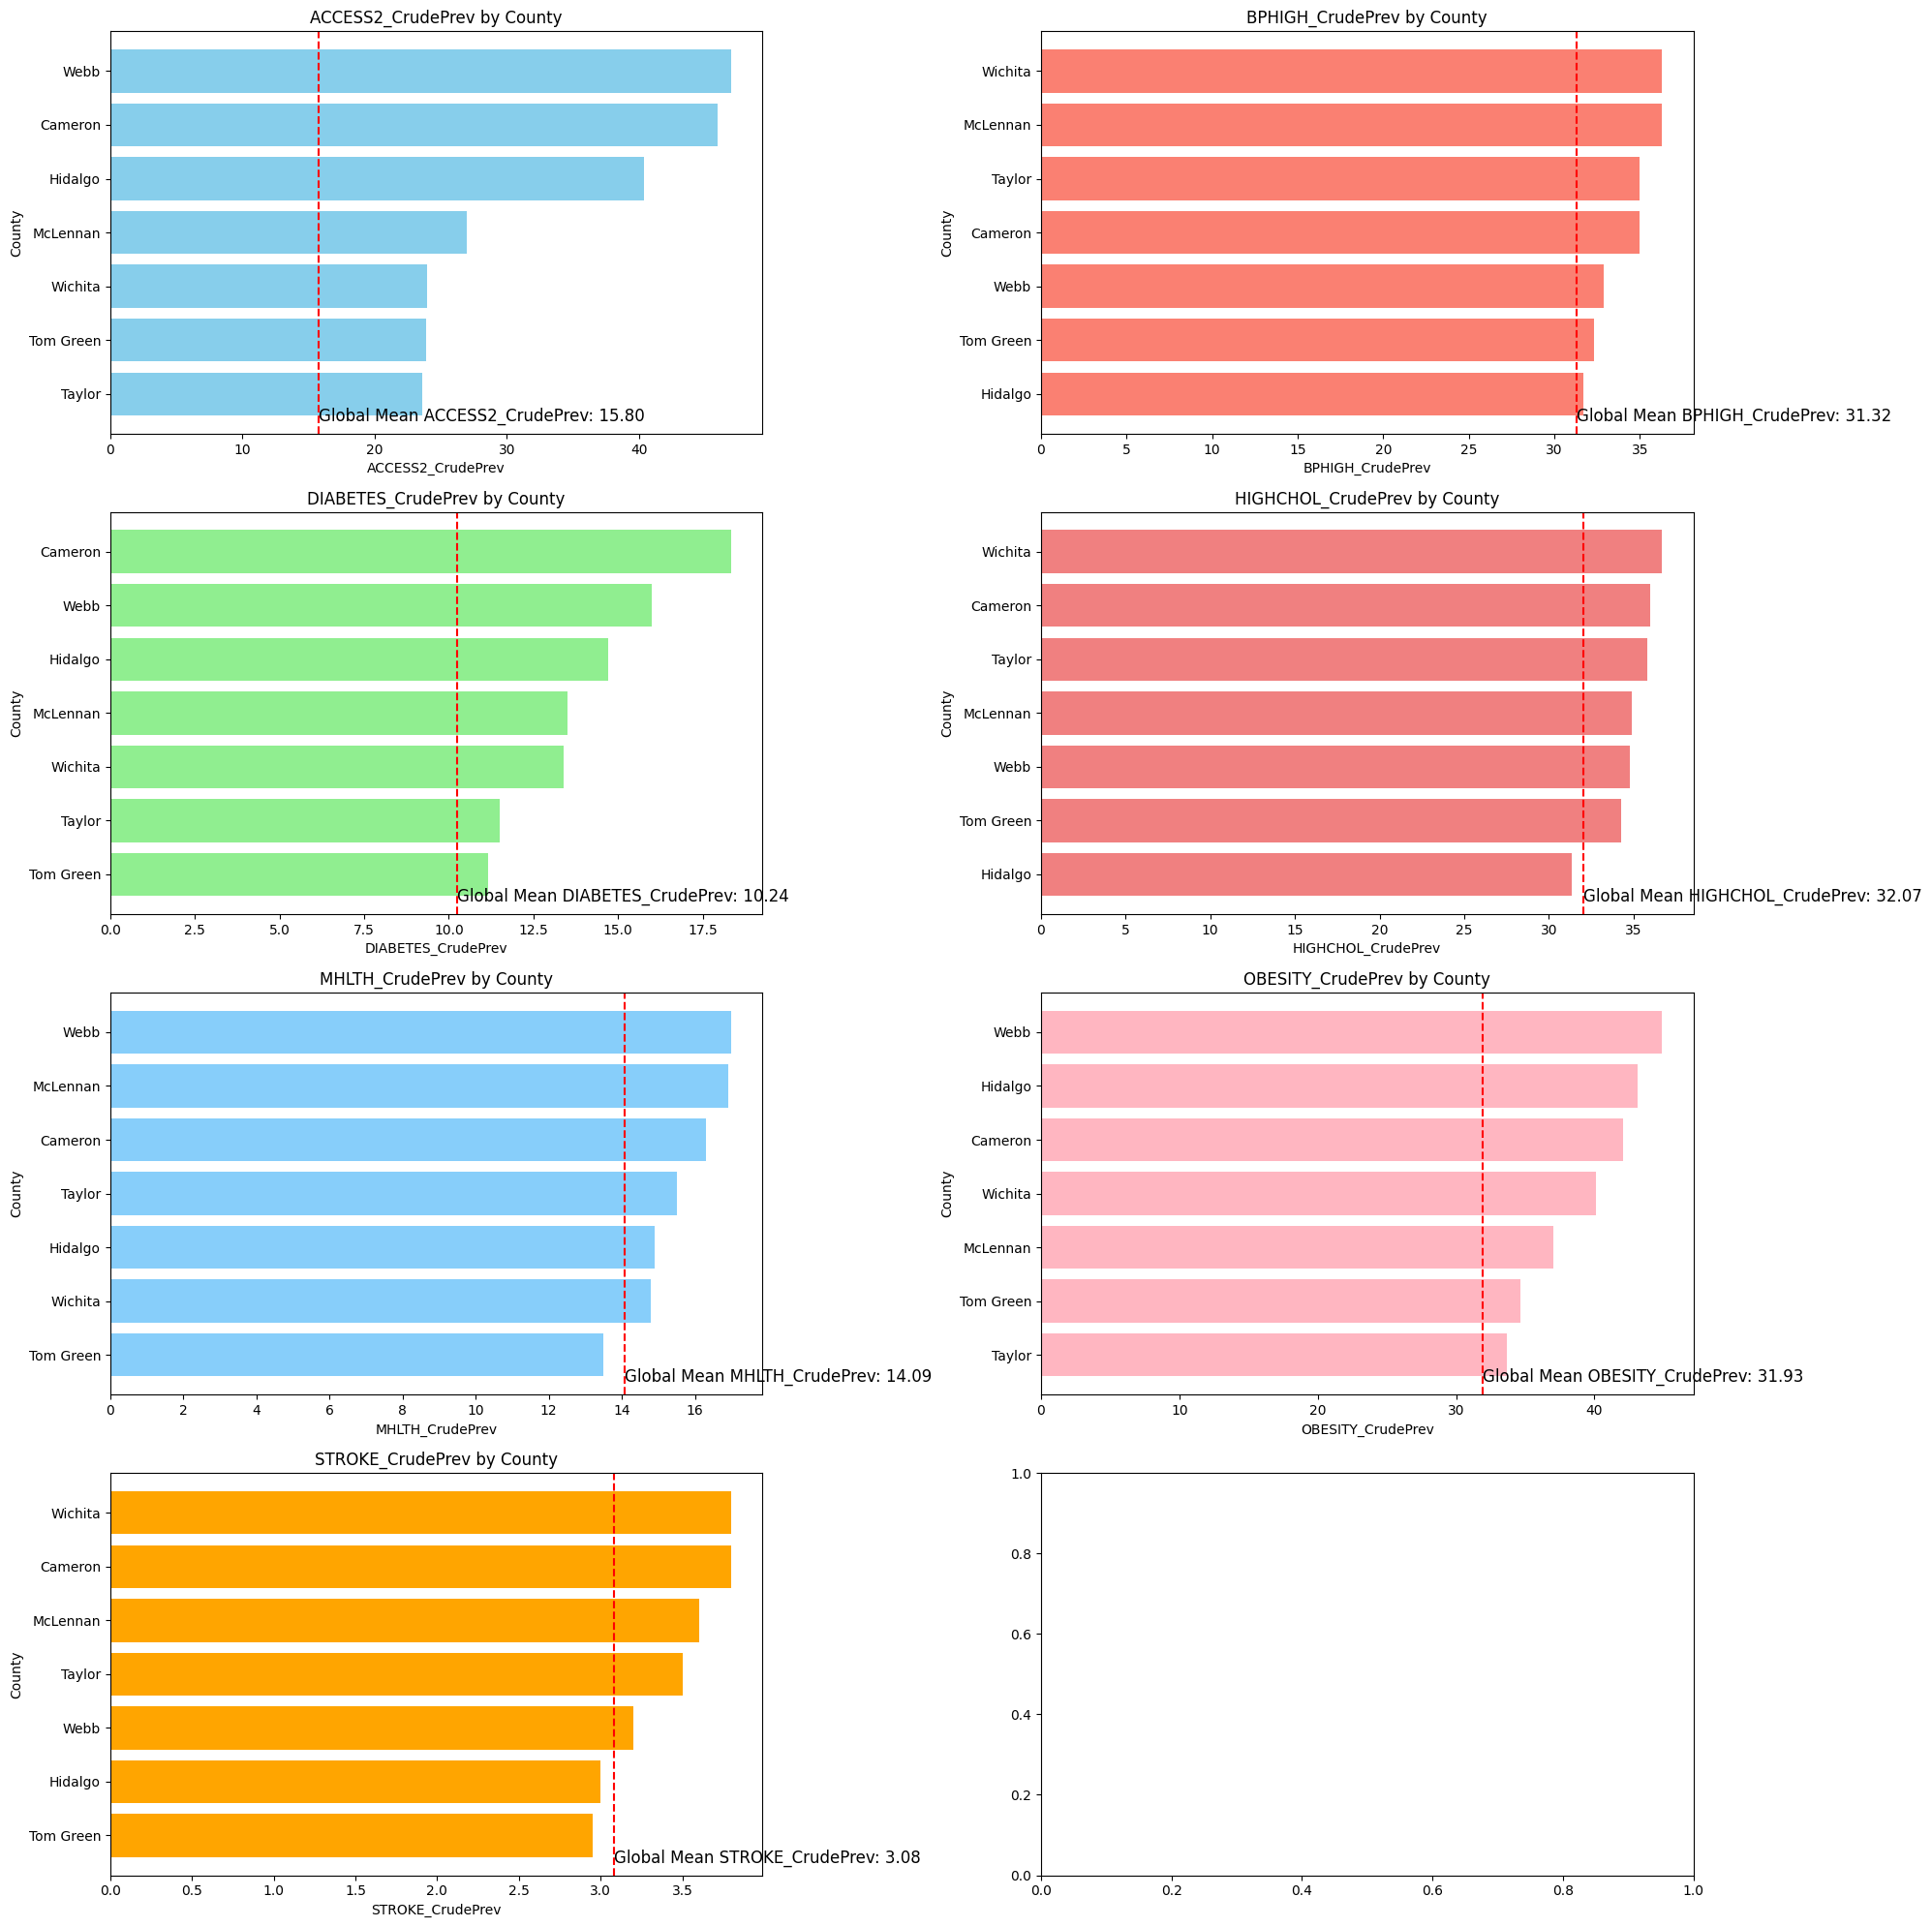

In [178]:
# Paleta de colores para cambiar de color en cada gráfico
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'orange']

# Crear la figura y los ejes para la grilla de gráficos
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
axes = axes.flatten()  # Aplana el array de ejes

# Crear gráficos de barras horizontales para cada variable
for i, var in enumerate(chronic_disease_labs):
    # Ordenar los datos en orden descendente
    ordered_data = texas.sort_values(by=var, ascending=True)
    
    # Graficar en el eje correspondiente
    ax = axes[i]
    ax.barh(ordered_data['County'], ordered_data[var], color=colors[i % len(colors)])
    ax.set_xlabel(var)
    ax.set_ylabel('County')
    ax.set_title(f'{var} by County')
    
    # Añadir línea de referencia de la media en rojo
    mean_value = df[var].mean()
    ax.axvline(mean_value, color='red', linestyle='--', linewidth=1.5)
    ax.text(mean_value, -0.5, f'Global Mean {var}: {mean_value:.2f}', color='black', fontsize=12)

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()
    
    

As observed in the graphs, all our selected counties are above the global average for almost all the chronic diseases studied. The projected impact could be a reduction in the prevalence of these diseases over a period of 6 months to 1 year. By conducting medical check-ups before starting the program, we can determine our starting point and compare the progress of our actions every 6 months, reevaluating based on the participants' parameters.

In [ ]:

# Close the connection
conn.close()
